# Comm 461 Assignment 3 


** SUBMITTED BY: **

Zacharias van Zyl - 20148761, Cassandra Harvey - 20176074, Jack Liston - 20169600, Stephen Abbott 20150887, Matthew Martin - 20162349

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

---
## Ensemble Learning

In this part of the assignment, we look at [Ensemble Methods with sklearn](http://scikit-learn.org/stable/modules/ensemble.html). Specifically, we use [Forests of randomized trees](http://scikit-learn.org/stable/modules/ensemble.html#forest), [Gradient Tree Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

### Classifiction using Forest of Randomized Trees

The code below trains a `RandomForestClassifier` on the iris dataset.

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris["target"], test_size=0.33, random_state=15)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train,y_train)
rnd_pred = rnd_clf.predict(X_test)

print(rnd_clf.__class__.__name__, accuracy_score(y_test, rnd_pred))

RandomForestClassifier 0.96


If you look at a single Decision Tree, important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves (or not at all). It is therefore possible to get an estimate of a feature’s importance by computing the average depth at which it appears across all trees in the forest. This can give a quick idea of what features actually matter if you need to perform feature selection

In [3]:
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09944464547042393
sepal width (cm) 0.02613603333730799
petal length (cm) 0.4641201742718116
petal width (cm) 0.41029914692045644


### **Question 1**  
Use the cell below to train a classifier of your choice using only petal length and petal width and compare the accuracy to the one of the Random Forest. (Hint: length and width are the last two columns of the data array.) 

In [5]:
from sklearn.tree import DecisionTreeClassifier

# drop sepal length and width
X = iris["data"][:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, iris["target"], test_size=0.33, random_state=15)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print(tree.__class__.__name__, accuracy_score(y_test, tree_pred))

DecisionTreeClassifier 0.94


### Regression using Gradient Tree Boosting

The code below uses `GradientBoostingRegressor` on sample data.

In [6]:
# Data Sampling
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 10*X[:, 0]**3 + .08 * np.random.randn(100)

In [7]:
# Training
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

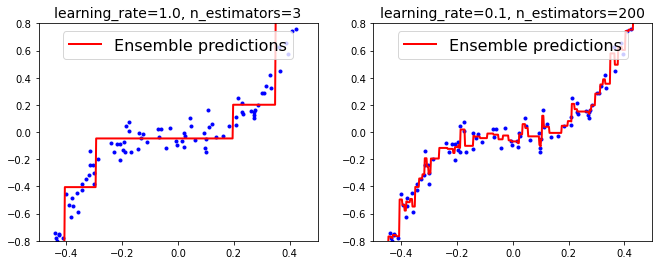

In [8]:
# Plotting
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.8, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.8, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

#### As you can see, the model on the left underfits the data and the model on the right overfits the data.

### **Question 2**  
Which model parameters can you adjust to optimize the fit?

---

To optimize the fit, we can adjust the following parameters: learning rate, number of estimators, and max depth.

---

### Classification using Stacked Generalization

In this section, we combine the various ensemble methods learned to create a model stack for classification task.

The task is to perform optical character recognition by classifying handwritten numbers from 0 to 9. Here is a sample of our training data from the dataset called MNIST:

![numbers](data/numbers.png)

The following code loads the MNIST data, and splits it into a training set, and a test set.

If you run the code below, you might receive an error, saying that certain modules are not available.
Remeber that Python is a modular language, and sometimes the modules (or packages as some might call it) are not loaded by default. For this task we need to add 2 modules to our coding environment: "keras" and "tensorflow". Here is a link explaining how to add them to your environment:
https://www.geeksforgeeks.org/python-add-packages-to-anaconda-environment/

In [9]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#printing the shapes of the vectors 
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

11490434/11490434 [==============================] - 1s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


### **Question 3**  

*Step 1: Build individual ensemble classifiers.*

Train a [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and a [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) using `X_train` and `y_train`.

Use each of the two models to predict the values of `y_test` and calculate the accuracy compared to `y_test`.

*Step 2: Create a stacked train_set*

Combine the two resulting sets of predictions into a new set called `X_train_pred`. This dataset has 2 columns, which are the predictions performed in step 1.

*Step 3: Training on the new dataset*

Train a new `RandomForestClassifier` using the new `X_train_pred`, and previous`y_train` to create a blender.

Unlike the original dataset, this model has the predictions from step 1  as train data, but the target is the same as step 1.

Use this blender to predict `y_test` and compare the accuracy against actual values of `y_test`. Compare the accuracy of this new blender model with the ones acheived using the individual classifiers in step 1.

In [17]:
# Reshape the data to 2D
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [16]:
# Random Forest
mnist_rf = RandomForestClassifier()

mnist_rf.fit(X_train, y_train)
mnist_rf_pred = mnist_rf.predict(X_test)

print(accuracy_score(y_test, mnist_rf_pred))

0.9707


In [18]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

mnist_gbt = GradientBoostingClassifier()
mnist_gbt.fit(X_train, y_train)
mnist_gbt_pred = mnist_gbt.predict(X_test)

print(accuracy_score(y_test, mnist_gbt_pred))

0.9459


In [19]:
# Step 2
X_train_pred = np.column_stack((mnist_rf_pred, mnist_gbt_pred))

In [20]:
# Blender
blender = RandomForestClassifier()

blender.fit(X_train_pred, y_test)
blender_pred = blender.predict(X_train_pred)

print(accuracy_score(y_test, blender_pred))

0.9725


The blended model has a higher accuracy than the individual models. However, the blended model is only marginally better than the Random Forest Model.

### Using Artificial Neural Networks for Classification
In this part, we want to use ANN for classification. More specifically, we use a Multi-layer Perceptron to do so.
[Scikit Learn](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) has necessary tools to develop such a model. 

### **Question 4** 
Using MNIST data set, develop an ANN classifier with LBFGS solver and $\alpha = 1e-5$. Use one hidden layer of size 50 and without random state. If a parameter is not mentioned in this description, use the default values.

Use the same train set as in the last question and then test it on the test set and measure its accuracy and the time spent to solve it.
(You can use *%%time* magic for a cell to measure the time spent to finish that cell. You just have to type *%%time* at the beginning of the cell.)


In [24]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    alpha=1e-5,
    solver='lbfgs',
)

mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

/Users/zaaisvanzyl/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training set score: 0.861883
Test set score: 0.855400
CPU times: user 7min 4s, sys: 53.3 s, total: 7min 57s
Wall time: 1min 4s


### **Question 5**
By changing the parameters in your ANN model above, develop 3 variations in the cells below. In each case, measure time and accuracy. At the end, choose one of these 4 (including the original model you developed above) explaining why you chose it.

In [27]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    alpha=1e-5,
    solver='lbfgs',
)

mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

/Users/zaaisvanzyl/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training set score: 0.952783
Test set score: 0.944100
CPU times: user 8min 54s, sys: 55.1 s, total: 9min 49s
Wall time: 1min 16s


In [28]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(200,),
    alpha=1e-5,
    solver='lbfgs',
)

mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

/Users/zaaisvanzyl/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training set score: 0.983550
Test set score: 0.960400
CPU times: user 12min 20s, sys: 1min 12s, total: 13min 33s
Wall time: 1min 49s


In [29]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(500,),
    alpha=1e-5,
    solver='lbfgs',
)

mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.969900
CPU times: user 10min 1s, sys: 3min 49s, total: 13min 50s
Wall time: 2min 22s


We will choose the second model (with a hidden layer size of 200). It has a high test set score, and a favourable training time. The last model has the highest test set score, but also shows significant evidence of overfitting.

## Using PCA 
Let's Apply PCA here to see if we can reduce the dimension of our data while retaining most of the variation. You may remeber from the course that one of the applications of PCA is to reduce dimensionality by finding the eigen vectors and eigen values and then mapping the whole dataset into the new space defined by those vectors.

To do so, we use PCA package from [Scikit Learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

### **Question 6**
Apply PCA on the same data (MNIST) to reduce the dimension of the data while retaining 95% of the variance. As for the rest of the parameters, go with the default settings. At the end, measure the variance you explained from the original data and also save your data in new nd_array named X_PCA.

hint: you can call your model pca and then look at pca.fit_transform(X) and its shape and pca.explained_variance_ratio_

remember that this should happen on X which has X_train and y_train together


In [37]:
# Import PCA
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=0.95)

# Print starting shape
print("Starting shape: ", X_train.shape)

# Apply the fit_transform method of pca to digits: pca_features
pca_features = pca.fit_transform(X_train)

# Print the shape of pca_features
print("Reduced shape: ", pca_features.shape)

# Print variance ratio\
print(pca.explained_variance_ratio_)


Starting shape:  (60000, 784)
Reduced shape:  (60000, 154)
[0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001 0.0210919  0.02022991
 0.01715818 0.01692111 0.01578641 0.01482953 0.01324561 0.01276897
 0.01187263 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786366 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586582 0.00570021 0.00543628
 0.00505786 0.00487859 0.00481429 0.00472266 0.00456747 0.00444836
 0.00418501 0.00398215 0.00384975 0.00375103 0.00362009 0.00351591
 0.00340058 0.00321874 0.00319017 0.00312805 0.00295983 0.00288955
 0.0028413  0.00271436 0.00269521 0.00258473 0.00253771 0.00244781
 0.00240506 0.00239263 0.00230408 0.00221532 0.00213721 0.00207225
 0.00203043 0.00196783 0.00192853 0.00188632 0.00186977 0.00181083
 0.00177562 0.00174898 0.00165758 0.00163894 0.00161462 0.00155116
 0.00147613 0.00143176 0.00142094 0.00141153 0.00140174 0.00135736
 0.

### **Question 7**
Having the new matrix X_PCA, prepare new sets of train and test data along with the corresponding labels.


In [38]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_features, y_train, test_size=0.2, random_state=42)

### **Quesetion 8** 
Pick the model of your choice from question 5, and this time train it on this new data set you made in question 7. Measure time and accuracy, and then write your insights about this process (from question 5 upto this part).

In [40]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(200,),
    alpha=1e-5,
    solver='lbfgs',
)

mlp.fit(X_train_pca, y_train_pca)

print("Training set score: %f" % mlp.score(X_train_pca, y_train_pca))
print("Test set score: %f" % mlp.score(X_test_pca, y_test_pca))

Training set score: 1.000000
Test set score: 0.958500
CPU times: user 3min 49s, sys: 47.9 s, total: 4min 37s
Wall time: 34.1 s


This combination of first applying PCA and the using a neural network is a good way to maintain model performance while limiting model complexity. It allows for a more efficient use of computational resources. However, it is important to note that the model is not as accurate as the original model, and also shows evidence of overfitting (100% accuracy on training set).

### **Thank you!**
For an amazing experience. Your feedback is always appreciated!. Let me know what you did and did not like in this course.